#### Setup

In [56]:
import matplotlib.pyplot as plt
import numpy as np

import torch

import pyciemss
from pyciemss.PetriNetODE.interfaces import setup_model, reset_model, intervene, sample, calibrate, optimize, load_petri_model
import mira
from pyciemss.utils import get_tspan

import warnings
warnings.filterwarnings('ignore')

In [104]:
### Plotting Utils ###

COLORS=['red','green','blue','black','gold']
def plot_trajectories(sol, tspan, data=None):
    if len(sol[list(sol.keys())[3]]) == 1:
        fig = plt.figure(facecolor='w', figsize=(6, 6))
        ax = fig.add_subplot(111, axisbelow=True)
        if data: d_keys = [list(x[1].keys())[0] for x in data] # get affected variables
        else: d_keys = []
        for i,var in enumerate(list(solution.keys())[2:]): # skip beta, gamma parameters
            ax.plot(tspan, sol[var].squeeze().detach().numpy(), COLORS[i], alpha=0.5, lw=3, label=var)
            if var[:-4] in d_keys: # there is training data of this variable
                x = np.array([x[0] for x in data if var[:-4] in list(x[1].keys())])
                y = np.array([x[1][var[:-4]] for x in data if var[:-4] in list(x[1].keys())]) # without _sol prefix
                ax.scatter(x,y,label=var[:-4]+" data",color=COLORS[i])
        ax.legend()
    else:
        print('! There is more than one trajectory data !')
        return
        # do the fill between min and max instead

## SIR MIRA

### Load and show model (prior)

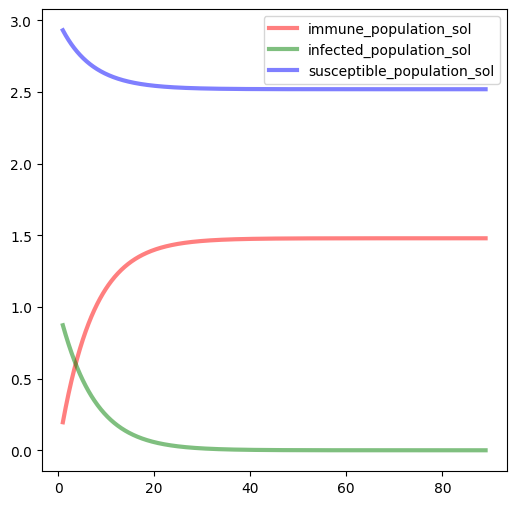

In [12]:
from mira.examples.sir import sir_parameterized as sir
full_tspan = get_tspan(1, 89, 890)
mira_model = load_petri_model(sir, add_uncertainty=True)
mira_model = setup_model(mira_model, start_time=0, start_state=dict(susceptible_population=3.0,
                                                                    infected_population=1.0,
                                                                    immune_population=0.0))
solution = sample(mira_model, timepoints=full_tspan, num_samples=1)

plot_trajectories(solution,full_tspan)
plt.show()

### Calibrate on data (posterior)

iteration 0: loss = 14.903801679611206
iteration 25: loss = 13.404856204986572


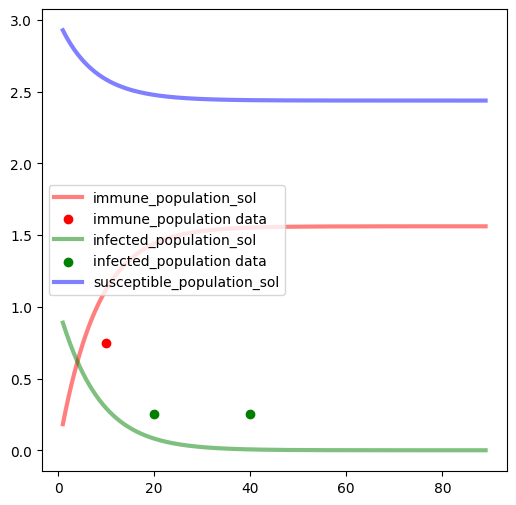

In [105]:
# data in the form list[ tuple(timepoint, dict(variable, observation)) , ...]
data = [(20.0,dict(infected_population=0.25)),
        (10.0,dict(immune_population=0.75)),
        (40.0,dict(infected_population=0.25))]
infer_mira = calibrate(mira_model,data, num_iterations=26, verbose=True)

calib_solution = sample(mira_model, timepoints=full_tspan, num_samples=1, inferred_parameters=infer_mira)

plot_trajectories(calib_solution,full_tspan,data)
plt.show()

## SIR Handmade

### Load and show model (prior)

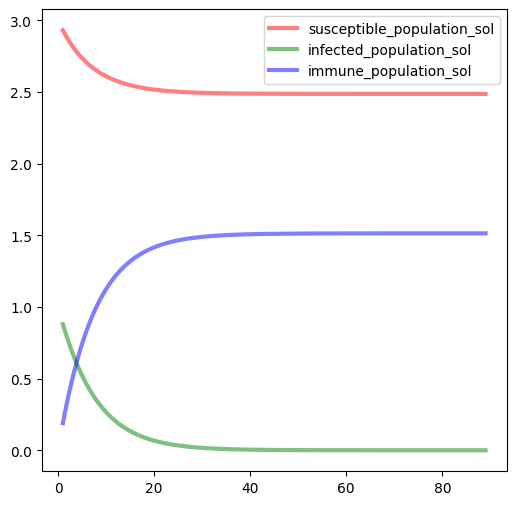

In [83]:
from pyciemss.PetriNetODE.models import SIR_with_uncertainty
from pyro.infer import Predictive
full_tspan = get_tspan(1, 89, 890)
SIR_model  = SIR_with_uncertainty(N=100.0, beta=0.1, gamma=0.2) # N here unecessary, makes its own
SIR_model = setup_model(SIR_model, start_time=0, start_state=dict(susceptible_population=3.0,
                                                                  infected_population=1.0,
                                                                  immune_population=0.0))
solution   = sample(SIR_model,full_tspan,1)

plot_trajectories(solution,full_tspan)
plt.show()

### Calibrate on data (posterior)

iteration 0: loss = 13.063814997673035
iteration 25: loss = 12.741014242172241
iteration 50: loss = 9.255695939064026
iteration 75: loss = 10.386765241622925
iteration 100: loss = 9.780842304229736


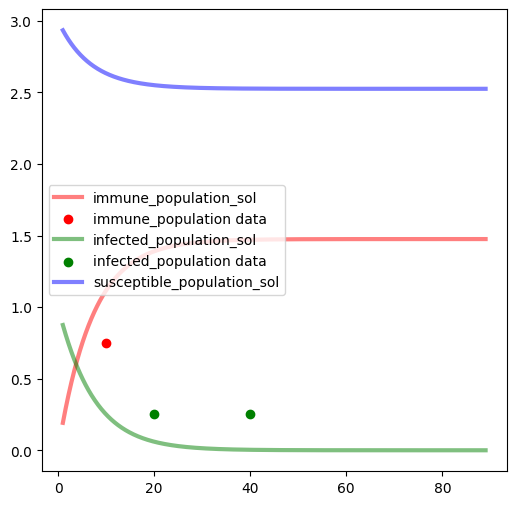

In [109]:
# data in the form list[ tuple(timepoint, dict(variable, observation)) , ...]
data = [(20.0,dict(infected_population=0.25)),
        (10.0,dict(immune_population=0.75)),
        (40.0,dict(infected_population=0.25))]
infer_SIR = calibrate(SIR_model,data, num_iterations=101, verbose=True)

calib_solution = sample(SIR_model, timepoints=full_tspan, num_samples=1, inferred_parameters=infer_SIR)

plot_trajectories(calib_solution,full_tspan,data)
plt.show()